In [1]:
import os
import cv2
from  tqdm  import  tqdm 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
from skimage import feature as ft
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
import xgboost
from sklearn.svm import SVC

In [2]:
# 图像均衡化，分三通道分别均衡化再合一
def equalize(image):
    b,g,r = cv2.split(image)
    # 依次均衡化
    b = cv2.equalizeHist(b)
    g = cv2.equalizeHist(g)
    r = cv2.equalizeHist(r)
    # 结合成一个图像
    equ_img = cv2.merge((b,g,r))
    
    return equ_img

# 提取图片中绿色（叶子）的部分
def extractGreen(image):
    lower_green = np.array([35, 43, 46], dtype="uint8")  # 绿色下限
    upper_green = np.array([90, 255, 255], dtype="uint8")  # 绿色上限
    
    # 高斯滤波
    img_blur = cv2.GaussianBlur(image, (3, 3), 0)
    img_blur = cv2.cvtColor(img_blur, cv2.COLOR_BGR2HSV)
    # 根据阈值找到对应颜色，二值化
    mask = cv2.inRange(img_blur, lower_green, upper_green)
    
    # 掩膜函数
    output = cv2.bitwise_and(image, image, mask=mask)

    return output

# 提取图像的SIFT特征点
def sift_feature(image_list):
    feature_sift_list = []  # SIFT特征向量列表

    sift = cv2.xfeatures2d.SIFT_create()
    
    for i in tqdm(range(len(image_list))):
        # 转为灰度图
        image = cv2.cvtColor(image_list[i], cv2.COLOR_BGR2GRAY)
        # 获取SIFT特征，kp为关键点信息，des为关键点特征矩阵形式
        kp, des = sift.detectAndCompute(image, None)
        if i < 1:
            img=cv2.drawKeypoints(image,kp,image_list[i])#绘制关键点
            #print(des,des.shape)
            plt.imshow(img)
        feature_sift_list.append(des)
    return feature_sift_list

def resize(image):
        image = cv2.resize(image, (128, 128)) 
        return image

# 标准化
def normalize(feature):
    scaler = StandardScaler()
    scaler.fit(feature)
    feature_normal = scaler.transform(feature)
    
    return feature_normal

In [3]:
from glob import glob

img_train = []
label_train = []

train_root = './plant_seed/train/*/*.png'
all_files = glob(train_root)

label_dict = {'Black-grass':0, 'Charlock':1, 'Cleavers':2, 'Common Chickweed':3, 'Common wheat':4, 'Fat Hen':5, 'Loose Silky-bent':6, 
             'Maize':7, 'Scentless Mayweed':8, 'Shepherds Purse':9, 'Small-flowered Cranesbill':10, 'Sugar beet':11}
for img_file in all_files:
    img_train.append(resize(cv2.imread(img_file)))
    label_train.append(label_dict[img_file.split('\\')[-2]])

label_train = pd.DataFrame(label_train)
all_label = np.array(label_train)

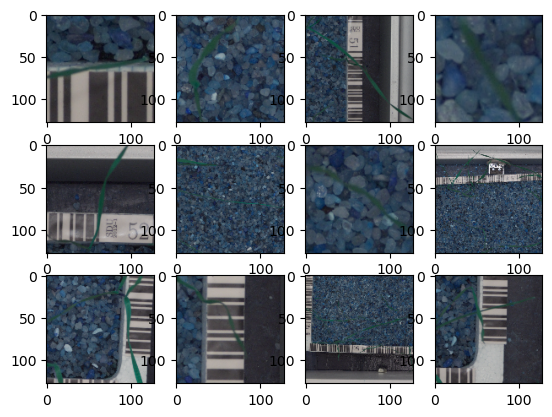

In [4]:
for i in range(0,12):
    plt.subplot(3, 4, i+1)
    plt.imshow(img_train[i])

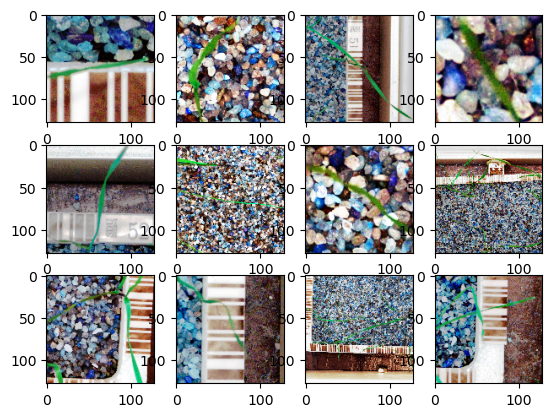

In [5]:
equ_train = []

#均衡化图片，不然特征不清晰
for image in img_train:
    equ_train.append(equalize(image))
for i in range(0, 12):
    plt.subplot(3, 4, i+1)
    plt.imshow(equ_train[i])

In [6]:
# def get_green_train(path):
    
# #     print("path=%s"%path)
#     img_classes=os.listdir(path)

#     train_list=[]
#     eval_list=[]

#     label=0
#     cnt=0
#     for img_class in img_classes:
#         label_dict[str(label)]=img_class
# #         print("{}:{}".format(label,img_class))

#         img_class_path=os.path.join(path,img_class)
#         imgs=os.listdir(img_class_path)
#         for img in imgs:
#             img_path=os.path.join(img_class_path,img)
#             cv2.imwrite(img_path,extractGreen(equalize(resize(cv2.imread(img_path)))))
            
# get_green_train('./plant_seed/train/')

In [7]:
# def get_green_test(path):
    
#     imgs=os.listdir(path)

#     for img in imgs:
#         img_path=os.path.join(path,img)
#         cv2.imwrite(img_path,extractGreen(equalize(resize(cv2.imread(img_path)))))
            
# get_green_test('./plant_seed/test/')

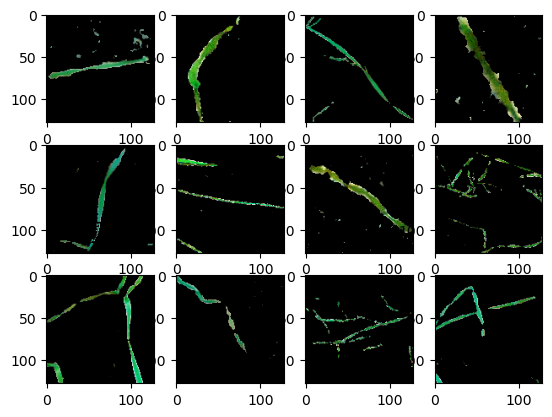

In [8]:
green_train = []

#绿色阈值二值化后，使用掩膜函数得到绿色图片
for image in equ_train:
    green_train.append(extractGreen(image))
    
for i in range(0, 12):
    plt.subplot(3, 4, i+1)
    plt.imshow(green_train[i])

100%|█████████████████████████████████████████████████████████████████████████████| 4750/4750 [00:14<00:00, 319.94it/s]


[array([[ 17.,  90.,  12., ...,   0.,   0.,   1.],
        [ 10.,  12.,   6., ...,  10.,   1.,   2.],
        [  9.,  37.,  45., ...,   0.,   0.,   0.],
        ...,
        [  4.,  28.,  35., ...,  12.,   1.,   0.],
        [  7.,  85., 100., ...,   0.,   6., 118.],
        [  1.,  15.,   4., ...,   3.,  19.,  92.]], dtype=float32),
 array([[18., 74., 67., ...,  2., 14.,  6.],
        [18.,  8., 16., ...,  7.,  8., 15.],
        [ 0.,  0.,  0., ...,  6.,  3.,  1.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  3., 66.],
        [ 9.,  6., 11., ...,  1.,  1.,  8.],
        [34., 30., 20., ...,  0.,  0.,  0.]], dtype=float32),
 array([[ 8.,  5.,  2., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 17.,  3.,  2.],
        [ 0.,  0.,  0., ...,  5.,  8., 23.],
        ...,
        [11., 45.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  0., ...,  1., 65., 63.],
        [16., 10.,  8., ...,  0.,  0.,  0.]], dtype=float32),
 array([[  0.,   0.,   3., ...,   1.,  10.,  27.],
        [ 31.

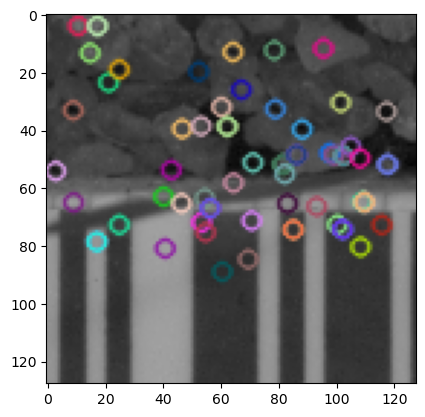

In [9]:
sift_feature(img_train)

100%|█████████████████████████████████████████████████████████████████████████████| 4750/4750 [00:13<00:00, 355.11it/s]


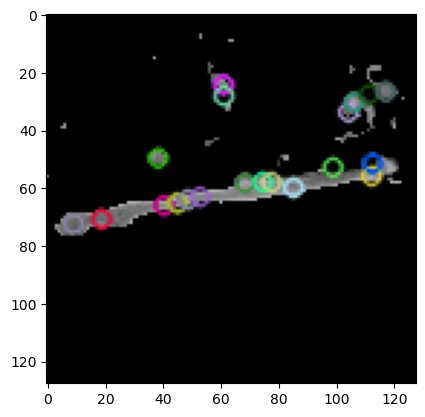

In [10]:
#第一次运行cv2.xfeatures2d.SIFT_create()报错，卸载opencv后，pip install opencv-contrib-python解决
feature_sift_list = sift_feature(green_train)

In [11]:
# 初始化BOW训练器
def bow_init(feature_sift_list):
    # 创建BOW训练器，指定k-means参数k   把处理好的特征数据全部合并，利用聚类把特征词分为若干类，此若干类的数目由自己设定，每一类相当于一个视觉词汇
    bow_kmeans_trainer = cv2.BOWKMeansTrainer(50)
    
    for feature_sift in feature_sift_list:
        bow_kmeans_trainer.add(feature_sift)
    
    # 进行k-means聚类，返回词汇字典 也就是聚类中心
    voc = bow_kmeans_trainer.cluster()
    
    # 输出词汇字典
    print(voc)
    print(type(voc),voc.shape)
    
    # FLANN匹配  
    # algorithm用来指定匹配所使用的算法，可以选择的有LinearIndex、KTreeIndex、KMeansIndex、CompositeIndex和AutotuneInde
    # 这里选择的是KTreeIndex(使用kd树实现最近邻搜索)
    flann_params = dict(algorithm=1,tree=5)
    flann = cv2.FlannBasedMatcher(flann_params,{})
    
    #初始化bow提取器(设置词汇字典),用于提取每一张图像的BOW特征描述
    sift = cv2.xfeatures2d.SIFT_create()
    bow_img_descriptor_extractor = cv2.BOWImgDescriptorExtractor(sift, flann)        
    bow_img_descriptor_extractor.setVocabulary(voc)
    
    return bow_img_descriptor_extractor

# 提取BOW特征
def bow_feature(bow_img_descriptor_extractor, image_list):
    # 分别对每个图片提取BOW特征，获得BOW特征列表
    feature_bow_list = [] 
    sift = cv2.xfeatures2d.SIFT_create()
    for i in tqdm(range(len(image_list))):
        image = cv2.cvtColor(image_list[i], cv2.COLOR_BGR2GRAY)
        feature_bow = bow_img_descriptor_extractor.compute(image,sift.detect(image))
        feature_bow_list.append(feature_bow)
    return np.array(feature_bow_list)[:,0,:]

feature_bow_list = bow_feature(bow_init(feature_sift_list), green_train)
feature_bow_list.shape

[[43.983414  33.025772  10.802779  ... 48.154415  32.379425  14.387046 ]
 [33.50189    3.9796882  1.3507321 ...  7.6360416  5.8927727  7.887104 ]
 [84.66861   26.248392   5.072472  ... 22.892168   4.4736996  3.9237287]
 ...
 [ 7.3469014  6.376977   5.164117  ... 13.959554   4.5071297  2.9219599]
 [ 7.3700156  6.2164683  6.090368  ... 35.74935   31.271362  20.659245 ]
 [ 1.1493369  1.6578896  3.5838938 ...  2.356525   1.8610417  3.979435 ]]
<class 'numpy.ndarray'> (50, 128)


100%|█████████████████████████████████████████████████████████████████████████████| 4750/4750 [00:23<00:00, 201.72it/s]


(4750, 50)

In [12]:
# 提取HOG特征
def hog_feature(image_list):
    feature_hog_list = []
    for i in tqdm(range(len(image_list))):
        feature_hog = ft.hog(image_list[i], orientations=16, pixels_per_cell=(32, 32), cells_per_block=(3, 3), 
                             feature_vector=True, multichannel=True)
        feature_hog_list.append(feature_hog)
    
    return np.array(feature_hog_list)

feature_hog_list = hog_feature(green_train)
feature_hog_list.shape

  0%|                                                                                         | 0/4750 [00:00<?, ?it/s]C:\Users\Dell\AppData\Local\Temp\ipykernel_572\1844036967.py:5: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  feature_hog = ft.hog(image_list[i], orientations=16, pixels_per_cell=(32, 32), cells_per_block=(3, 3),
100%|█████████████████████████████████████████████████████████████████████████████| 4750/4750 [00:12<00:00, 383.50it/s]


(4750, 576)

In [13]:
# 标准化以后特征矩阵全变0.，感觉有问题，暂时不运行标准化

feature_normal_hog = normalize(feature_hog_list)
feature_normal_hog

array([[-0.64968379, -0.4972246 , -0.48874533, ..., -0.442615  ,
        -0.4583779 , -0.4542165 ],
       [-0.64968379, -0.4972246 , -0.48874533, ..., -0.442615  ,
        -0.4583779 , -0.4542165 ],
       [ 0.98130534, -0.24507831, -0.13289596, ..., -0.442615  ,
        -0.03406499, -0.40499148],
       ...,
       [-0.64968379, -0.4972246 , -0.48874533, ..., -0.442615  ,
        -0.4583779 , -0.4542165 ],
       [ 1.75645302, -0.16113688, -0.48874533, ..., -0.442615  ,
        -0.4583779 , -0.4542165 ],
       [-0.64968379, -0.4972246 , -0.48874533, ...,  0.84295678,
         1.09199921,  0.18696807]])

In [14]:
# final_feature = [[] for i in range(4750)]

# all_feature = [feature_bow_list,feature_hog_list]
# # feature_normal_list = np.array(feature_normal_list)
# # print(np.array(feature_bow_list).shape,np.array(all_feature).shape)
# for feature in tqdm(feature_bow_list):
#     final_feature = np.hstack((final_feature, all_feature))

# final_feature.shape

In [15]:
# 将提取出的特征数组（二维）保存到npy文件中
def save_feature(feature, fileName):
    np.save('./plant_seed/' + fileName + '.npy', feature, allow_pickle=True)
    print(fileName + '.npy', '文件已生成！')

# 读取 之前保存好的 feature文件，返回特征矩阵（二维数组）
def read_feature(fileName):
    feature = np.load('./plant_seed/'+ fileName + '.npy', allow_pickle=True)
    print('已读取', fileName, '文件！\t shape = ', feature.shape)
    return feature

In [16]:
# save_feature(feature_bow_list, 'bow_feature')

In [17]:
# feature_bow_list = np.load('bow_feature.npy')

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit

# final_feature = feature_bow_list
final_feature = feature_normal_hog
# 按类划分数据集
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
sss.get_n_splits(final_feature, all_label)
for train_index, test_index in sss.split(final_feature, all_label):
    x_train, x_val = final_feature[train_index], final_feature[test_index]
    y_train, y_val = all_label[train_index], all_label[test_index]

print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(3800, 576) (950, 576) (3800, 1) (950, 1)


In [19]:
import time
# XGBoost模型
start = time.time()
model_xgb = XGBClassifier(learning_rate=0.1, objective='multi:softmax', num_class=12, n_estimators=500, tree_method='hist', max_depth=7, 
                          min_child_weight=3, max_delta_step=3, subsample=0.7, gamma=0, n_jobs=-1,use_label_encoder=False)


# early_stopping_rounds：n次幂以后，参数变化不大，就停止
model_xgb.fit(x_train, y_train, early_stopping_rounds=15, eval_set=[(x_val, y_val)], eval_metric='mlogloss', verbose=1)
score_xgb = model_xgb.score(x_val, y_val)
print('score_xgb =', score_xgb)
print("Train time: {0}".format(time.time() - start))

E:\anaconda\envs\project\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
E:\anaconda\envs\project\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
E:\anaconda\envs\project\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:2.39747
[1]	validation_0-mlogloss:2.30848
[2]	validation_0-mlogloss:2.23012
[3]	validation_0-mlogloss:2.15585
[4]	validation_0-mlogloss:2.09462
[5]	validation_0-mlogloss:2.03792
[6]	validation_0-mlogloss:1.99145
[7]	validation_0-mlogloss:1.94565
[8]	validation_0-mlogloss:1.89946
[9]	validation_0-mlogloss:1.86078
[10]	validation_0-mlogloss:1.82530
[11]	validation_0-mlogloss:1.79173
[12]	validation_0-mlogloss:1.76119
[13]	validation_0-mlogloss:1.73277
[14]	validation_0-mlogloss:1.70467
[15]	validation_0-mlogloss:1.67825
[16]	validation_0-mlogloss:1.65731
[17]	validation_0-mlogloss:1.63441
[18]	validation_0-mlogloss:1.61077
[19]	validation_0-mlogloss:1.58734
[20]	validation_0-mlogloss:1.56608
[21]	validation_0-mlogloss:1.54596
[22]	validation_0-mlogloss:1.53041
[23]	validation_0-mlogloss:1.51306
[24]	validation_0-mlogloss:1.49623
[25]	validation_0-mlogloss:1.48152
[26]	validation_0-mlogloss:1.46760
[27]	validation_0-mlogloss:1.45097
[28]	validation_0-mlogloss:1.4

[231]	validation_0-mlogloss:1.00018
[232]	validation_0-mlogloss:1.00032
[233]	validation_0-mlogloss:1.00040
[234]	validation_0-mlogloss:0.99996
[235]	validation_0-mlogloss:0.99992
[236]	validation_0-mlogloss:0.99978
[237]	validation_0-mlogloss:0.99959
[238]	validation_0-mlogloss:1.00001
[239]	validation_0-mlogloss:1.00008
[240]	validation_0-mlogloss:1.00008
[241]	validation_0-mlogloss:1.00078
[242]	validation_0-mlogloss:1.00081
[243]	validation_0-mlogloss:1.00005
[244]	validation_0-mlogloss:0.99991
[245]	validation_0-mlogloss:0.99973
[246]	validation_0-mlogloss:0.99999
[247]	validation_0-mlogloss:1.00011
[248]	validation_0-mlogloss:0.99947
[249]	validation_0-mlogloss:0.99956
[250]	validation_0-mlogloss:0.99967
[251]	validation_0-mlogloss:0.99919
[252]	validation_0-mlogloss:0.99910
[253]	validation_0-mlogloss:0.99912
[254]	validation_0-mlogloss:0.99950
[255]	validation_0-mlogloss:0.99972
[256]	validation_0-mlogloss:0.99922
[257]	validation_0-mlogloss:0.99905
[258]	validation_0-mlogloss:

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# 展示各类的准确率、召回率、f1-score，及可视化
def category_show(model, x_val, y_val):
    label_names = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed','Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
                    'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
    y_pred = model.predict(x_val)
    print(classification_report(y_val, y_pred, target_names=label_names))
    cm = confusion_matrix(y_val, y_pred)
    cm_display = ConfusionMatrixDisplay(cm).plot()

                           precision    recall  f1-score   support

              Black-grass       0.19      0.06      0.09        53
                 Charlock       0.66      0.73      0.69        78
                 Cleavers       0.73      0.66      0.69        58
         Common Chickweed       0.69      0.77      0.73       122
             Common wheat       0.27      0.09      0.14        44
                  Fat Hen       0.65      0.64      0.65        95
         Loose Silky-bent       0.63      0.87      0.73       131
                    Maize       0.64      0.48      0.55        44
        Scentless Mayweed       0.63      0.64      0.63       103
          Shepherds Purse       0.44      0.37      0.40        46
Small-flowered Cranesbill       0.89      0.95      0.92        99
               Sugar beet       0.59      0.66      0.63        77

                 accuracy                           0.65       950
                macro avg       0.58      0.58      0.57    

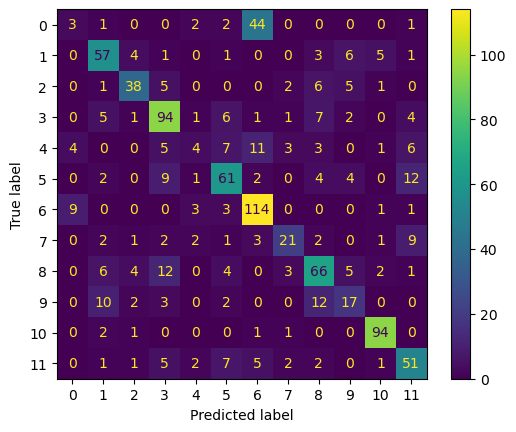

In [21]:
category_show(model_xgb, x_val, y_val)

In [22]:
model_xgb.save_model('ML_project_xgbmodel.json')
print("模型保存成功")

模型保存成功


In [23]:
img_test = []
name_test = []

test_root = './plant_seed/test/*.png'
test_files = glob(test_root)

for img_file in test_files:
    img_test.append(resize(cv2.imread(img_file)))
    name_test.append(img_file.split('\\')[-1])

0021e90e4.png


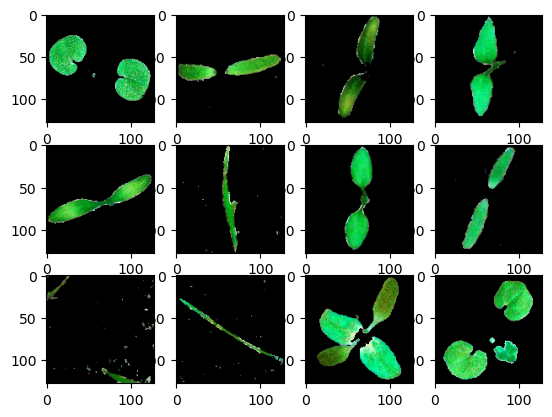

In [24]:
green_test = []
for image in img_test:
    green_test.append(extractGreen(equalize(image)))
    
for i in range(0, 12):
    plt.subplot(3, 4, i+1)
    plt.imshow(green_test[i])

print(name_test[0])

In [25]:
# test_bow = bow_feature(bow_init(sift_feature(green_test)), green_test)

test_bow = hog_feature(green_test)
test_bow = normalize(test_bow)

  0%|                                                                                          | 0/794 [00:00<?, ?it/s]C:\Users\Dell\AppData\Local\Temp\ipykernel_572\1844036967.py:5: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  feature_hog = ft.hog(image_list[i], orientations=16, pixels_per_cell=(32, 32), cells_per_block=(3, 3),
100%|███████████████████████████████████████████████████████████████████████████████| 794/794 [00:02<00:00, 363.75it/s]


In [26]:
import xgboost as xgb
model_xgb_pre = xgb.Booster()
model_xgb_pre.load_model("ML_project_xgbmodel.json")

pred = model_xgb_pre.predict(xgb.DMatrix(test_bow))

predlabel = []
for i in range(pred.shape[0]):
    predlabel.append(list(label_dict.keys())[list(label_dict.values()).index(pred[i])])

res = pd.DataFrame({'file': name_test, 'species': predlabel})
res.to_csv("submission.csv", index=False)

In [27]:
model_svm = SVC()
model_svm.fit(x_train, y_train)
score_svm = model_svm.score(x_val, y_val)
print('score_svm =', score_svm)

E:\anaconda\envs\project\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


score_svm = 0.6905263157894737


E:\anaconda\envs\project\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\anaconda\envs\project\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\anaconda\envs\project\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                           precision    recall  f1-score   support

              Black-grass       0.00      0.00      0.00        53
                 Charlock       0.74      0.83      0.78        78
                 Cleavers       0.82      0.64      0.72        58
         Common Chickweed       0.70      0.75      0.72       122
             Common wheat       0.59      0.23      0.33        44
                  Fat Hen       0.70      0.71      0.70        95
         Loose Silky-bent       0.58      0.95      0.72       131
                    Maize       0.78      0.57      0.66        44
        Scentless Mayweed       0.65      0.68      0.67       103
          Shepherds Purse       0.51      0.43      0.47        46
Small-flowered Cranesbill       0.90      0.95      0.93        99
               Sugar beet       0.68      0.69      0.68        77

                 accuracy                           0.69       950
                macro avg       0.64      0.62      0.61    

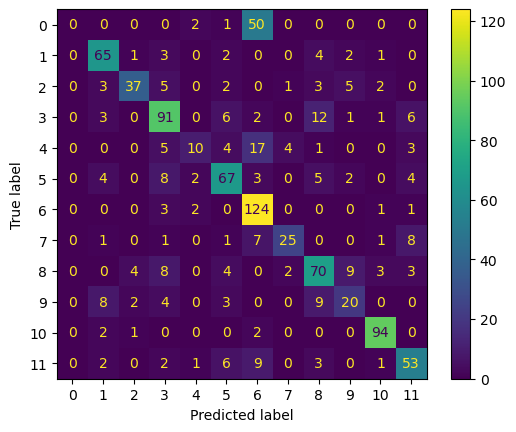

In [28]:
category_show(model_svm, x_val, y_val)

In [29]:
import joblib
joblib.dump(model_svm, "ML_project_svmmodel.m")
print("模型保存成功")

模型保存成功


In [31]:
model_svm_pre = joblib.load("ML_project_svmmodel.m")

pred = model_svm_pre.predict(test_bow)

predlabel = []
for i in range(pred.shape[0]):
    predlabel.append(list(label_dict.keys())[list(label_dict.values()).index(pred[i])])

res = pd.DataFrame({'file': name_test, 'species': predlabel})
res.to_csv("submission.csv", index=False)